<a href="https://colab.research.google.com/github/Karima277/Fine-tune-stable-diffusion-using-Lora-on-Pokemon-Dataset/blob/main/fine_tune_stableDuffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning Stable duffusion ON Pokemon Datasets !


**install datasets**

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Training Code

In [2]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from transformers import CLIPTextModel, CLIPTokenizer
from accelerate import Accelerator
from huggingface_hub import HfApi, HfFolder
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import wandb
from PIL import Image

# Configuration
# MODEL_NAME = "runwayml/stable-diffusion-v1-5"
MODEL_NAME = "CompVis/stable-diffusion-v1-4"
DATASET_NAME = "alc15492/pokemonreplica"
OUTPUT_DIR = "./pokemon-lora"
TRAIN_BATCH_SIZE = 2
EVAL_BATCH_SIZE = 2
NUM_EPOCHS = 2
LEARNING_RATE = 1e-4
GRADIENT_ACCUMULATION_STEPS = 32
MIXED_PRECISION = "fp16"

# Setup
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Initialize accelerator
accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    log_with="wandb"
)

# Initialize wandb
wandb.init(project="pokemon-stable-diffusion-lora", config={
    "learning_rate": LEARNING_RATE,
    "batch_size": TRAIN_BATCH_SIZE,
    "epochs": NUM_EPOCHS
})

# Load model and tokenizer
pipeline = StableDiffusionPipeline.from_pretrained(MODEL_NAME)
tokenizer = CLIPTokenizer.from_pretrained(MODEL_NAME, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(MODEL_NAME, subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained(MODEL_NAME, subfolder="unet")
noise_scheduler = pipeline.scheduler

# Freeze parameters
text_encoder.requires_grad_(False)
unet.requires_grad_(False)

# Configure LoRA
lora_config = LoraConfig(
    r=4,
    lora_alpha=32,
    target_modules=["to_q", "to_v"],
    lora_dropout=0.1,
    bias="none",
    task_type="stable_diffusion"
)

# Prepare model with LoRA
unet = get_peft_model(unet, lora_config)

# Create a new LoRA config for the text encoder with appropriate target modules
text_encoder_lora_config = LoraConfig(
    r=4,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="feature_extraction"
)

text_encoder = get_peft_model(text_encoder, text_encoder_lora_config)

# Prepare model for training
unet = prepare_model_for_kbit_training(unet)
text_encoder = prepare_model_for_kbit_training(text_encoder)

# Load dataset
def process_dataset(examples):
    print(f"Processing batch with {len(examples['image'])} images")
    print(f"Text descriptions: {examples['text']}")
    # Tokenize text
    inputs = tokenizer(
        examples['text'],
        max_length=tokenizer.model_max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    # Transform images
    transform = transforms.Compose([
        transforms.Resize((125, 125)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    # Apply transforms directly to the PIL Images
    images = [transform(img) for img in examples['image']]

    return {
        "input_ids": inputs.input_ids.squeeze(),
        "pixel_values": torch.stack(images),
        "text_description": examples['text'],
        "attention_mask": inputs.attention_mask.squeeze()
    }

# Load and preprocess dataset
dataset = load_dataset(DATASET_NAME)
processed_dataset = dataset['train'].select(range(50)).with_transform(process_dataset)
#processed_dataset = dataset['train'].with_transform(process_dataset)

# Create DataLoader
train_dataloader = DataLoader(
    processed_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True
)

# Optimizer
optimizer = torch.optim.AdamW(
    list(unet.parameters()) + list(text_encoder.parameters()),
    lr=LEARNING_RATE
)

# Learning rate scheduler
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * NUM_EPOCHS)
)

# Prepare everything with accelerator
unet, text_encoder, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    unet, text_encoder, optimizer, train_dataloader, lr_scheduler
)


# Move VAE to the correct device
pipeline.vae = pipeline.vae.to(accelerator.device)
# Convert pixel values to latent space
def get_latents(pixel_values):
    # Use VAE to convert pixel values to latent space
    latents = pipeline.vae.encode(pixel_values).latent_dist.sample()
    latents = latents * 0.18215
    return latents

for epoch in range(NUM_EPOCHS):
    unet.train()
    text_encoder.train()

    total_loss = 0
    for batch_idx, batch in enumerate(train_dataloader): # Enumerate to get batch index
        # Zero gradients
        print(f"Batch {batch_idx}")  # Now batch_idx is defined
        print(f"Batch keys: {batch.keys()}")
        print(f"Pixel values shape: {batch['pixel_values'].shape}")
        print(f"Input IDs shape: {batch['input_ids'].shape}")
        optimizer.zero_grad()

        # Prepare inputs
        pixel_values = batch['pixel_values']
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']

        # Convert pixel values to latents
        latents = get_latents(pixel_values)

        # Encode text
        encoder_hidden_states = text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )[0]

        # Sample noise
        noise = torch.randn_like(latents)

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0,
            noise_scheduler.config.num_train_timesteps,
            (latents.shape[0],),
            device=latents.device
        ).long()

        # Add noise to latents according to the noise scheduler
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Predict noise residual
        model_pred = unet(
            sample=noisy_latents,
            timestep=timesteps,
            encoder_hidden_states=encoder_hidden_states
        ).sample

        # Compute loss
        loss = F.mse_loss(model_pred, noise, reduction="mean")

        # Backward pass
        accelerator.backward(loss)

        # Update weights
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()

        # Log metrics
        wandb.log({
            "loss": loss.item(),
            "learning_rate": lr_scheduler.get_last_lr()[0]
        })

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Average Loss: {total_loss/len(train_dataloader)}")

# Save the model
unet.save_pretrained(os.path.join(OUTPUT_DIR, "unet"))
text_encoder.save_pretrained(os.path.join(OUTPUT_DIR, "text_encoder"))

print("Training complete!")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: ERROR API key must be 40 characters long, yours was 21


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

dataset_infos.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

(…)-00000-of-00001-566cc9b19d7203f8.parquet:   0%|          | 0.00/99.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

Processing batch with 2 images
Text descriptions: ['a drawing of a blue sea turtle holding a rock', 'a drawing of a blue dragon with red eyes']
Processing batch with 2 images
Text descriptions: ['a drawing of a yellow and white pikachu', 'a drawing of a girl with a boxing glove']
Batch 0
Batch keys: dict_keys(['input_ids', 'pixel_values', 'text_description', 'attention_mask'])
Pixel values shape: torch.Size([2, 3, 125, 125])
Input IDs shape: torch.Size([2, 77])
Processing batch with 2 images
Text descriptions: ['a drawing of a star with a jewel in the center', 'a cartoon butterfly with a sad look on its face']
Batch 1
Batch keys: dict_keys(['input_ids', 'pixel_values', 'text_description', 'attention_mask'])
Pixel values shape: torch.Size([2, 3, 125, 125])
Input IDs shape: torch.Size([2, 77])
Processing batch with 2 images
Text descriptions: ['a very cute looking pokemon character', 'a purple ball with a skull and cross bones on it']
Batch 2
Batch keys: dict_keys(['input_ids', 'pixel_va

In [3]:
# Save the model
unet.save_pretrained(os.path.join(OUTPUT_DIR, "unet"))
text_encoder.save_pretrained(os.path.join(OUTPUT_DIR, "text_encoder"))

## Using the model to generate new images

In [13]:
import torch
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer
from peft import PeftModel, PeftConfig

# Model paths
BASE_MODEL = "CompVis/stable-diffusion-v1-4"
LORA_MODEL_PATH = "./pokemon-lora"

# Load base models
tokenizer = CLIPTokenizer.from_pretrained(BASE_MODEL, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(BASE_MODEL, subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained(BASE_MODEL, subfolder="unet")

# Load LoRA weights
unet = PeftModel.from_pretrained(unet, f"{LORA_MODEL_PATH}/unet")
text_encoder = PeftModel.from_pretrained(text_encoder, f"{LORA_MODEL_PATH}/text_encoder")

# Create pipeline
pipeline = StableDiffusionPipeline.from_pretrained(BASE_MODEL)
pipeline.unet = unet
pipeline.text_encoder = text_encoder

# Optional: Move to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
pipeline = pipeline.to(device)

# Function to generate images
def generate_pokemon_image(prompt, num_inference_steps=50, guidance_scale=7.5):
    """
    Generate an image based on the given prompt using the fine-tuned Pokemon LoRA model.

    Args:
    - prompt (str): Text description of the image to generate
    - num_inference_steps (int, optional): Number of denoising steps. Defaults to 50.
    - guidance_scale (float, optional): How closely the image generation follows the prompt. Defaults to 7.5.

    Returns:
    - PIL.Image: Generated image
    """
    # Generate image
    image = pipeline(
        prompt,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale
    ).images[0]

    return image


if __name__ == "__main__":
    # Try generating a few Pokemon-style images
    prompts = [
        "A cute electric type Pokemon in a forest",
        "Realistic Pikachu standing on a rock",
        "Legendary dragon Pokemon flying over mountains"
    ]

    for prompt in prompts:
        print(f"Generating image for prompt: {prompt}")
        image = generate_pokemon_image(prompt)

        # Save the generated image
        image.save(f"generated_pokemon_{prompt.replace(' ', '_')}.png")
        print(f"Image saved for: {prompt}")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Generating image for prompt: A cute electric type Pokemon in a forest


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved for: A cute electric type Pokemon in a forest
Generating image for prompt: Realistic Pikachu standing on a rock


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved for: Realistic Pikachu standing on a rock
Generating image for prompt: Legendary dragon Pokemon flying over mountains


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved for: Legendary dragon Pokemon flying over mountains


## Displaying generated images

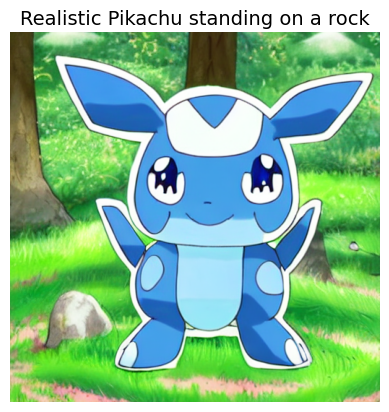

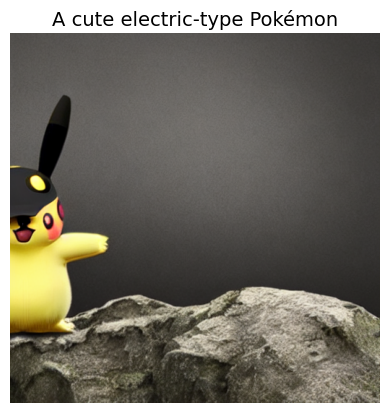

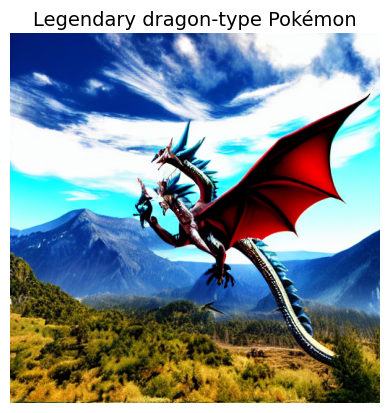

In [19]:
import matplotlib.pyplot as plt
import os

# Directory containing your images
image_directory = "/content/"

# List of image files with their prompts
images_with_prompts = [
    {
        "file": "generated_pokemon_A_cute_electric_type_Pokemon_in_a_forest.png",
        "prompt": "Realistic Pikachu standing on a rock"
    },
    {
        "file": "generated_pokemon_Realistic_Pikachu_standing_on_a_rock.png",
        "prompt": "A cute electric-type Pokémon"
    },
    {
        "file": "generated_pokemon_Legendary_dragon_Pokemon_flying_over_mountains.png",
        "prompt": "Legendary dragon-type Pokémon"
    },
]

# Display each image with its prompt
for item in images_with_prompts:
    image_path = os.path.join(image_directory, item["file"])
    image = plt.imread(image_path)

    plt.imshow(image)
    plt.axis('off')
    plt.title(item["prompt"], fontsize=14)
    plt.show()
